<a href="https://colab.research.google.com/github/canxiu-zhang/ML_YUniv/blob/main/ml_1010/weekly/week_3/bert_multi_label_multi_class_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [24]:
import subprocess
print((subprocess.check_output("lscpu", shell=True).strip()).decode())

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          2
On-line CPU(s) list:             0,1
Thread(s) per core:              2
Core(s) per socket:              1
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           79
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:                        0
CPU MHz:                         2200.150
BogoMIPS:                        4400.30
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       32 KiB
L1i cache:                       32 KiB
L2 cache:                        256 KiB
L3 cache:                        55 MiB
NUMA node0 CPU(s):               0,1
Vulnerability 

In [ ]:
!pip install transformers

In [25]:
#######################################
### -------- Load libraries ------- ###
# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
# And pandas for data import + sklearn because you allways need sklearn
import pandas as pd
from sklearn.model_selection import train_test_split

# Loading the Data

In [52]:
train_raw = pd.read_csv('consumer_complaints.csv')
train_raw.head()

<ipython-input-52-c9bd59dabc04>:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  train_raw = pd.read_csv('consumer_complaints.csv')


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [53]:
train_raw.shape

(555957, 18)

# Preprocessing Data

In [54]:
train_raw = train_raw[train_raw.consumer_complaint_narrative.notnull()]
train_raw.shape

(66806, 18)

<Axes: ylabel='Frequency'>

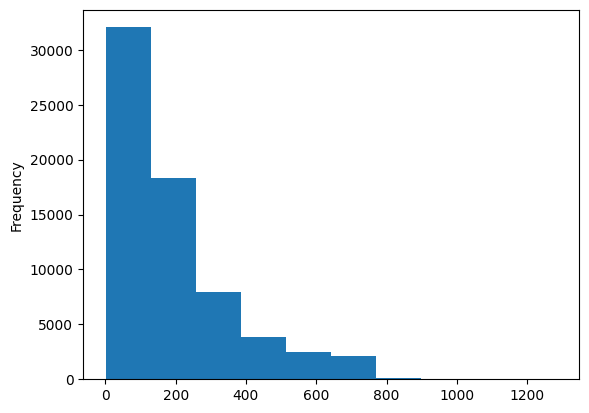

In [55]:
train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split())).plot(kind='hist')

In [56]:
train_raw['len_txt'] =train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split()))
train_raw.describe()

,complaint_id,len_txt
count,6.680600e+04,66806.000000
mean,1.571665e+06,190.644014
std,1.545692e+05,166.830597
min,1.290181e+06,1.000000
25%,1.443264e+06,71.000000
50%,1.569485e+06,136.000000
75%,1.702750e+06,254.000000
max,1.888608e+06,1284.000000


In [57]:
train_raw = train_raw[train_raw.len_txt >249]
train_raw.shape

(17142, 19)

In [58]:
train_raw = train_raw[['consumer_complaint_narrative', 'product']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
train_raw.at[train_raw['product'] == 'Credit reporting', 'product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
train_raw.at[train_raw['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Prepaid card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Payday loan', 'product'] = 'Payday loan, title loan, or personal loan'
train_raw.at[train_raw['product'] == 'Virtual currency', 'product'] = 'Money transfer, virtual currency, or money service'
train_raw.head()

In [60]:
import numpy as np
for l in np.unique(train_raw['product']):
  print(l)

Bank account or service
Consumer Loan
Credit card
Credit reporting
Debt collection
Money transfers
Mortgage
Other financial service
Payday loan
Prepaid card
Student loan


<Axes: >

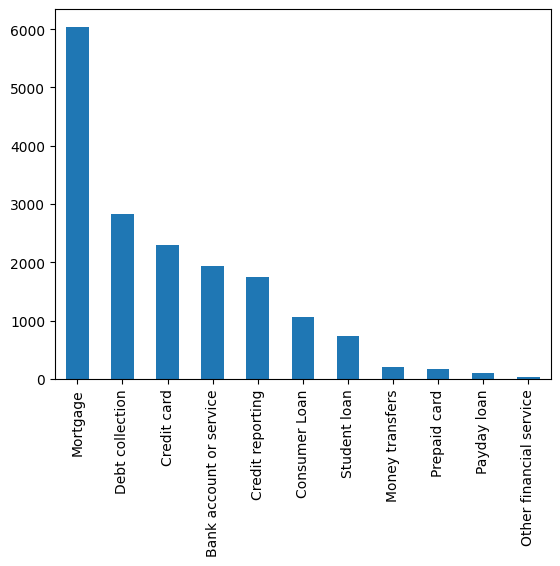

In [61]:
train_raw['product'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [62]:
train_raw=train_raw.rename(columns = {'consumer_complaint_narrative':'text', 'product':'label'})
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [63]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,6
1,XXXX was submitted XX/XX/XXXX. At the time I s...,6
2,I spoke to XXXX of green tree representatives ...,6
3,i opened XXXX Bank of America credit cards 15-...,2
4,I applied for a loan with XXXX XXXX and had pu...,1


In [64]:
len(np.unique(train_raw['label']))

11

In [65]:
train = train_raw.copy()

In [66]:
train = train.reindex(np.random.permutation(train.index))
train.head()

,text,label
7482,"On XXXX XXXX, 2015, I noticed a fraudulent cha...",0
4894,We called Capiital One Bank at XXXX at XX/XX/X...,2
9282,"A little over two years ago, I had a Macy 's d...",2
11935,On XXXX/XXXX/2016 I received an email stating ...,9
2290,"Dear CFPB, My name is XXXX XXXX and my husband...",0


Clean the text columns

In [67]:
import re
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)    
  return text

In [68]:
train['text']  = train.text.apply(clean_txt)
train.head()

,text,label
7482,On XXXX XXXX 2015 I noticed a fraudulent charg...,0
4894,We called Capiital One Bank at XXXX at XX XX X...,2
9282,A little over two years ago I had a Macy s dep...,2
11935,On XXXX XXXX 2016 I received an email stating ...,9
2290,Dear CFPB My name is XXXX XXXX and my husband ...,0


In [69]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)
train.head()

,text,label
13143,On XXXX XXXX 2016 I used my Capitol One 360 de...,0
9978,I filed an complaint with Barclays bank of Del...,2
8679,I have been attempting to resolve a dispute wi...,0
12277,I was contacted by Conns on XX XX 2016 to make...,4
12207,Have a loan with One Main financial formerly k...,1


In [70]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label
0,On XXXX XXXX 2016 I used my Capitol One 360 de...,0
1,I filed an complaint with Barclays bank of Del...,2


In [71]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,text,label
0,I changed homeowner insurance companies recent...,6
1,The servicer continually claims that the compl...,6


In [72]:
val.shape, train.shape

((3429, 2), (13713, 2))

# BERT: Use pretrained model to classify product and issue with Complaint Narrative

In [83]:
data = pd.read_csv('consumer_complaints.csv')

<ipython-input-83-0fe41c053794>:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('consumer_complaints.csv')


In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [85]:
data.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [86]:
data['product'].nunique()

11

In [87]:
data['issue'].nunique()

95

In [89]:
#######################################
### --------- Import data --------- ###
# Import data from csv

# Select required columns
data = data[['consumer_complaint_narrative', 'product', 'issue']]
# Remove a row if any of the three remaining columns are missing
data = data.dropna()
# Remove rows, where the label is present only ones (can't be split)
data = data.groupby('issue').filter(lambda x : len(x) > 1)
data = data.groupby('product').filter(lambda x : len(x) > 1)
# Set your model output as categorical and save in new label col
data['Issue_label'] = pd.Categorical(data['issue'])
data['Product_label'] = pd.Categorical(data['product'])
# Transform your output to numeric
data['issue'] = data['Issue_label'].cat.codes
data['product'] = data['Product_label'].cat.codes
# Split into train and test - stratify over Issue
data, data_test = train_test_split(data, test_size = 0.2, stratify = data[['issue']])

In [90]:
#######################################
### ------- Setup RoBERTa -------- ###
# Name of the BERT model to use
model_name = 'bert-base-uncased'
# Max length of tokens
max_length = 100
# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False
# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
 #transformer_model.layers[0]

In [92]:
#######################################
### ------- Build the model ------- ###
# TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model
# Load the MainLayer
bert = transformer_model.layers[0]
# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)
# Then build your model output
issue = Dense(units=len(data.Issue_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='issue')(pooled_output)
product = Dense(units=len(data.Product_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='product')(pooled_output)
outputs = {'issue': issue, 'product': product}
# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')
# Take a look at the model
model.summary()

Model: "BERT_MultiLabel_MultiClass"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 100,                      

In [ ]:
#######################################
### ------- Train the model ------- ###
# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss = {'issue': CategoricalCrossentropy(from_logits = True), 'product': CategoricalCrossentropy(from_logits = True)}
metric = {'issue': CategoricalAccuracy('accuracy'), 'product': CategoricalAccuracy('accuracy')}
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)
# Ready output data for the model
y_issue = to_categorical(data['issue'])
y_product = to_categorical(data['product'])
# Tokenize the input (takes some time)
x = tokenizer(
    text=data['consumer_complaint_narrative'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids'] , 'attention_mask': x['attention_mask']},
    y={'issue': y_issue, 'product': y_product},
    validation_split=0.2,
    batch_size=4,
    epochs=1)

 3787/10689 [=========>....................] - ETA: 10:32:19 - loss: 3.4909 - issue_loss: 2.6464 - product_loss: 0.8445 - issue_accuracy: 0.3387 - product_accuracy: 0.7567

In [ ]:
#######################################
### ----- Evaluate the model ------ ###
# Ready test data
# test_y_issue = to_categorical(data_test['issue'])
test_y_product = to_categorical(val['label'])
test_x = tokenizer(
    text=val['text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids'],'attention_mask': test_x['attention_mask']},
    y={'product': test_y_product}
)

In [ ]:
#model.predict('hello')